In [21]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler,normalize
import matplotlib.pyplot as plt
import process
from typing import Tuple
import torch

In [3]:
df_video = pd.read_csv('../data/video_info2.csv',index_col=0)

In [4]:
df_video.head(1)

,Unnamed: 0,key_id,mid,comment,typeid,play,pic,subtitle,description,copyright,...,meta_mid,is_avoided,attribute,is_charging_arc,vt,enable_vt,vt_display,playback_position,cur_time,length2
0,0,1,536913550.0,1.0,124.0,720.0,http://i0.hdslb.com/bfs/archive/ee57a0661b0f84...,NaN,视频来自youtube，视频上传已获得Rupert团队的邮件许可。\n注：视频字幕是由up付...,2.0,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.700031e+09,371


In [5]:
df_person = pd.read_excel('../data/personal_info.xlsx',index_col=0)

In [6]:
df_person.head(1)

,key_id,mid,uname,sex,birthday,fans,friend,attention,sign,cur_level,...,official_desc,official_type,official_veri_type,official_veri_desc,vip_type,vip_status,archive_count,article_count,follower,like_num
0,1,536913550.0,意识星球住民BeAware,保密,NaN,15792,1,1,Clean & Clear...,4,...,NaN,-1,-1,NaN,0,0,199,0,15792,47477


---
## personal information processing

### 生成对照表
#### 挂件

In [18]:
df_guajian = df_person[['pid','p_name']].drop_duplicates().reset_index(drop=True)
df_guajian.head()

,pid,p_name
0,0,NaN
1,1758,至尊戒
2,196,斗破苍穹
3,32428,RNG战队
4,2630,三周年恋曲


In [28]:
df_guajian.sort_values('pid').to_csv('../data/guajian.csv', index=False, encoding='utf-8-sig')

#### 勋章

In [17]:
df_xunzhang = df_person[['nid','n_name','n_level','n_condition']].drop_duplicates().reset_index(drop=True)
df_xunzhang.head()

,nid,n_name,n_level,n_condition
0,0,NaN,NaN,NaN
1,5,知名搬运工,高级勋章,转载视频投稿通过总数>=1000
2,8,知名偶像,稀有勋章,所有自制视频总播放数>=100万
3,3,白银殿堂,高级勋章,单个自制视频总播放数>=10万
4,4,青铜殿堂,普通勋章,单个自制视频总播放数>=1万


In [29]:
df_xunzhang.sort_values('nid').to_csv('../data/xunzhang.csv', index=False, encoding='utf-8-sig')

### 清洗

In [308]:
df_person_cl = df_person.drop(labels=['uname', 'birthday', 'article_count', 'sign', 'p_name', 'n_name',
                                      'n_condition', 'official_title', 'official_desc', 'attention', 'nid',
                                      'official_veri_type', 'official_veri_desc', 'key_id', 'follower'],axis=1)
df_person_cl.mid = df_person_cl.mid.astype(int)
df_person_cl.drop_duplicates(['mid'],inplace=True)
df_person_cl.reset_index(drop=True)

,mid,sex,fans,friend,cur_level,pid,n_level,official_role,official_type,vip_type,vip_status,archive_count,like_num
0,536913550,保密,15792,1,4,0,NaN,0,-1,0,0,199,47477
1,405007525,女,285645,6,6,0,高级勋章,0,-1,1,0,1683,1254539
2,686150641,保密,212919,54,5,0,NaN,3,1,1,0,10,89353
3,492840942,保密,19339097,57,6,0,NaN,3,1,1,1,63,400193
4,26389059,男,106738,13,6,0,稀有勋章,0,-1,1,0,134,585964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9209,238360699,男,37331,25,5,0,NaN,0,-1,1,0,63,897006
9210,173516096,女,931498,33,6,0,NaN,1,0,0,0,329,7431320
9211,365842307,男,587481,704,6,0,稀有勋章,1,0,2,1,169,1685787
9212,490818349,男,212934,59,6,0,稀有勋章,1,0,2,1,40,1637771


* fans, friend, archive_acount, like_num 都是厚尾分布，严重右偏，所以这些连续变量均取log
* sex, official_role, official_type, vip_type, vip_status, n_level 种类有限，视为分类变量并用onehot编码
* pid数量太多，取人数>10的pid进行onehot编码，其他的归为一类，pid=0的归为一类

In [309]:
# 部分nlevel是na
df_person_cl.loc[df_person_cl.n_level.isna(), 'n_level'] = 'None'
# 做onehot处理
df_person_cl = pd.concat([df_person_cl, pd.get_dummies(df_person_cl['sex'], prefix='sex').iloc[:,1:]], axis=1)
df_person_cl = pd.concat([df_person_cl, pd.get_dummies(df_person_cl['official_role'], prefix='official_role').iloc[:,1:]], axis=1)
df_person_cl = pd.concat([df_person_cl, pd.get_dummies(df_person_cl['official_type'], prefix='official_type').iloc[:,1:]], axis=1)
df_person_cl = pd.concat([df_person_cl, pd.get_dummies(df_person_cl['vip_type'], prefix='vip_type').iloc[:,1:]], axis=1)
df_person_cl = pd.concat([df_person_cl, pd.get_dummies(df_person_cl['vip_status'], prefix='vip_status').iloc[:,1:]], axis=1)
df_person_cl = pd.concat([df_person_cl, pd.get_dummies(df_person_cl['n_level'], prefix='n_level').iloc[:,1:]], axis=1)
# pid只取数量>10的，否则变量数太多
pidlist = list(df_person_cl.pid.value_counts()[df_person_cl.pid.value_counts()>10].index)
df_person_cl.loc[~df_person_cl.pid.isin(pidlist),'pid'] = 'others'
df_person_cl = pd.concat([df_person_cl, pd.get_dummies(df_person_cl['pid'], prefix='pid').iloc[:,1:]], axis=1)
# 删掉原来的变量
df_person_cl.drop(labels=['sex','official_role','official_type','vip_type','vip_status','n_level','pid'],inplace=True,axis=1)
# 对右偏变量取log
df_person_cl['fans'] = np.log(1+df_person_cl['fans'])
df_person_cl['friend'] = np.log(1+df_person_cl['friend'])
df_person_cl['archive_count'] = np.log(1+df_person_cl['archive_count'])
df_person_cl['like_num'] = np.log(1+df_person_cl['like_num'])
# 连续变量标准化
scaler = StandardScaler()
col_to_scale = ['fans','friend','cur_level','archive_count','like_num']
df_person_cl[col_to_scale] = scaler.fit_transform(df_person_cl[col_to_scale])
df_person_cl.head()

,mid,fans,friend,cur_level,archive_count,like_num,sex_女,sex_男,official_role_1,official_role_2,...,pid_1990,pid_2360,pid_2630,pid_3144,pid_3399,pid_5108,pid_32257,pid_53590,pid_55650,pid_others
0,536913550,-0.297973,-2.150486,-1.556379,0.459414,-0.405017,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,405007525,0.593111,-1.424451,0.491091,1.643499,0.470451,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,686150641,0.502673,-0.229761,-0.532644,-1.152493,-0.235943,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,492840942,1.890449,-0.198981,0.491091,-0.173826,0.164951,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26389059,0.290141,-1.022740,0.491091,0.240981,0.266905,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
df_person_cl.head(10).to_excel('/Users/apple/Desktop/tmp.xlsx')

In [310]:
df_person_cl.shape

(9214, 53)

---
## video information process

In [304]:
# 删除没有用的列
df_video_cl = df_video.drop(labels=['key_id','subtitle','review','is_steins_gate','attribute','Unnamed: 0','is_pay','meta_mid',
                                      'vt','enable_vt','vt_display','playback_position','title','pic', 'copyright','is_live_playback',
                                      'description','author','aid','is_avoided','length','meta_title','is_charging_arc'],axis=1)
# float to int
df_video_cl.mid = df_video_cl.mid.astype(int)
df_video_cl.typeid = df_video_cl.typeid.astype(int)
# 日期从int变日期
df_video_cl['created'] = pd.to_datetime(df_video_cl['created'], unit='s')
df_video_cl['cur_time'] = pd.to_datetime(df_video_cl['cur_time'], unit='s')
# 重新归纳视频分区
tname = pd.read_excel('../data/tname.xlsx')
tid_dic = {}
for i in range(tname.shape[0]):
    tid_dic[tname.loc[i,'typeid']] = tname.loc[i,'cat0']
df_video_cl['cat'] = df_video_cl['typeid'].apply(lambda x: tid_dic.get(x))
# 计算发布天数
df_video_cl['datediff'] = (df_video_cl.cur_time - df_video_cl.created).dt.days.astype(int)
# 标记是否是短视频
df_video_cl['if_short'] = df_video_cl.length2.apply(lambda x: 1 if x<60 else 0)
df_video_cl.drop(labels=['cur_time','created','typeid','meta_ep_count'],inplace=True,axis=1)

In [311]:
df_video_cl.head()

,mid,comment,play,video_review,bvid,is_union_video,if_meta,meta_id,length2,cat,datediff,if_short
0,536913550,1.0,720.0,1.0,BV1tj411E74n,0.0,0.0,NaN,371,知识,0,0
1,536913550,2.0,1138.0,1.0,BV17b4y1g7yC,0.0,0.0,NaN,654,知识,1,0
2,536913550,23.0,2657.0,0.0,BV1UC4y177sm,0.0,0.0,NaN,480,知识,2,0
3,536913550,15.0,1982.0,2.0,BV1GN411g7Y2,0.0,0.0,NaN,813,知识,3,0
4,536913550,1.0,1091.0,0.0,BV17g4y1979L,0.0,0.0,NaN,244,知识,4,0


In [ ]:
df_video_cl.head(100).to_excel('/Users/apple/Desktop/tmp.xlsx')

### 特征工程

In [263]:
duration_list = [7,15,30,90,180,365,365*3,365*5]
duration_name_list = ['7d','15d','30d','90d','180d','1y','3y','5y']

In [317]:
# comment number
def get_comment_number(df_p,df_v):
    df = pd.DataFrame(df_p['mid'])
    # 每个时间段的comment和
    for i in range(len(duration_list)):
        duration = duration_list[i]
        duration_name = duration_name_list[i]
        df_commenti = pd.DataFrame(df_v.loc[df_v.datediff<=duration,:].groupby(['mid'])['comment'].sum())
        df = pd.merge(df, df_commenti,how='left',left_on='mid',right_on='mid')
        df.loc[df.comment.isna(),'comment'] = 0
        df.rename(columns={'comment':'comment_'+duration_name},inplace=True)
    # 总comment
    df_commenti = pd.DataFrame(df_v.groupby(['mid'])['comment'].sum())
    df = pd.merge(df, df_commenti,how='left',left_on='mid',right_on='mid')
    df.loc[df.comment.isna(),'comment'] = 0
    df.rename(columns={'comment':'comment_ttl'},inplace=True)
    return pd.merge(df_p, df, how='left', left_on='mid', right_on='mid')

In [320]:
# plays
def get_plays(df_p,df_v):
    df = pd.DataFrame(df_p['mid'])
    # 每个时间段的play和
    for i in range(len(duration_list)):
        duration = duration_list[i]
        duration_name = duration_name_list[i]
        df_playi = pd.DataFrame(df_v.loc[df_v.datediff<=duration,:].groupby(['mid'])['play'].sum())
        df = pd.merge(df, df_playi,how='left',left_on='mid',right_on='mid')
        df.loc[df.play.isna(),'play'] = 0
        df.rename(columns={'play':'play_'+duration_name},inplace=True)
    # 总play
    df_playi = pd.DataFrame(df_v.groupby(['mid'])['play'].sum())
    df = pd.merge(df, df_playi,how='left',left_on='mid',right_on='mid')
    df.loc[df.play.isna(),'play'] = 0
    df.rename(columns={'play':'play_ttl'},inplace=True)
    return pd.merge(df_p, df, how='left', left_on='mid', right_on='mid')

In [344]:
# short_num
def get_short_num(df_p,df_v):
    df = pd.DataFrame(df_p['mid'])
    # 每个时间段的short_num和
    for i in range(len(duration_list)):
        duration = duration_list[i]
        duration_name = duration_name_list[i]

        df_short_numi = pd.DataFrame(df_v.loc[(df_v.datediff<=duration)&(df_v.if_short==1),:].groupby(['mid'])['bvid'].count())

        df = pd.merge(df, df_short_numi,how='left',left_on='mid',right_on='mid')
        df.loc[df.bvid.isna(),'bvid'] = 0
        df.rename(columns={'bvid':'short_num_'+duration_name},inplace=True)

    # 总short_num
    df_short_numi = pd.DataFrame(df_v.loc[df_v.if_short==1,:].groupby(['mid'])['bvid'].count())
    
    df = pd.merge(df, df_short_numi,how='left',left_on='mid',right_on='mid')
    df.loc[df.bvid.isna(),'bvid'] = 0
    df.rename(columns={'bvid':'short_num_ttl'},inplace=True)
    return pd.merge(df_p, df, how='left', left_on='mid', right_on='mid')

In [340]:
# long_num
def get_long_num(df_p,df_v):
    df = pd.DataFrame(df_p['mid'])
    # 每个时间段的long_num和
    for i in range(len(duration_list)):
        duration = duration_list[i]
        duration_name = duration_name_list[i]

        df_long_numi = pd.DataFrame(df_v.loc[(df_v.datediff<=duration)&(df_v.if_short==0),:].groupby(['mid'])['bvid'].count())

        df = pd.merge(df, df_long_numi,how='left',left_on='mid',right_on='mid')
        df.loc[df.bvid.isna(),'bvid'] = 0
        df.rename(columns={'bvid':'long_num_'+duration_name},inplace=True)

    # 总long_num
    df_long_numi = pd.DataFrame(df_v.loc[df_v.if_short==0,:].groupby(['mid'])['bvid'].count())
    
    df = pd.merge(df, df_long_numi,how='left',left_on='mid',right_on='mid')
    df.loc[df.bvid.isna(),'bvid'] = 0
    df.rename(columns={'bvid':'long_num_ttl'},inplace=True)
    return pd.merge(df_p, df, how='left', left_on='mid', right_on='mid')

In [346]:
# 视频总长度
def get_length(df_p,df_v):
    df = pd.DataFrame(df_p['mid'])
    # 每个时间段的视频总长度
    for i in range(len(duration_list)):
        duration = duration_list[i]
        duration_name = duration_name_list[i]

        df_length = pd.DataFrame(df_v.loc[(df_v.datediff<=duration),:].groupby(['mid'])['length2'].sum())

        df = pd.merge(df, df_length,how='left',left_on='mid',right_on='mid')
        df.loc[df.length2.isna(),'length2'] = 0
        df.rename(columns={'length2':'length_'+duration_name},inplace=True)

    # 视频总长度
    df_length = pd.DataFrame(df_v.groupby(['mid'])['length2'].sum())
    
    df = pd.merge(df, df_length,how='left',left_on='mid',right_on='mid')
    df.loc[df.length2.isna(),'length2'] = 0
    df.rename(columns={'length2':'length_ttl'},inplace=True)
    return pd.merge(df_p, df, how='left', left_on='mid', right_on='mid')

In [349]:
# video_review
def get_video_review(df_p,df_v):
    df = pd.DataFrame(df_p['mid'])
    # 每个时间段的video_review和
    for i in range(len(duration_list)):
        duration = duration_list[i]
        duration_name = duration_name_list[i]
        df_video_reviewi = pd.DataFrame(df_v.loc[df_v.datediff<=duration,:].groupby(['mid'])['video_review'].sum())
        df = pd.merge(df, df_video_reviewi,how='left',left_on='mid',right_on='mid')
        df.loc[df.video_review.isna(),'video_review'] = 0
        df.rename(columns={'video_review':'video_review_'+duration_name},inplace=True)
    # 总video_review
    df_video_reviewi = pd.DataFrame(df_v.groupby(['mid'])['video_review'].sum())
    df = pd.merge(df, df_video_reviewi,how='left',left_on='mid',right_on='mid')
    df.loc[df.video_review.isna(),'video_review'] = 0
    df.rename(columns={'video_review':'video_review_ttl'},inplace=True)
    return pd.merge(df_p, df, how='left', left_on='mid', right_on='mid')

In [354]:
# 联合投稿数量
def get_union_num(df_p,df_v):
    df = pd.DataFrame(df_p['mid'])
    # 每个时间段的union_num和
    for i in range(len(duration_list)):
        duration = duration_list[i]
        duration_name = duration_name_list[i]

        df_union_numi = pd.DataFrame(df_v.loc[(df_v.datediff<=duration)&(df_v.is_union_video==1),:].groupby(['mid'])['bvid'].count())

        df = pd.merge(df, df_union_numi,how='left',left_on='mid',right_on='mid')
        df.loc[df.bvid.isna(),'bvid'] = 0
        df.rename(columns={'bvid':'union_num_'+duration_name},inplace=True)

    # 总union_num
    df_union_numi = pd.DataFrame(df_v.loc[df_v.is_union_video==1,:].groupby(['mid'])['bvid'].count())
    
    df = pd.merge(df, df_union_numi,how='left',left_on='mid',right_on='mid')
    df.loc[df.bvid.isna(),'bvid'] = 0
    df.rename(columns={'bvid':'union_num_ttl'},inplace=True)
    return pd.merge(df_p, df, how='left', left_on='mid', right_on='mid')

In [378]:
# meta数量
def get_meta_num(df_p,df_v):
    df = pd.DataFrame(df_p['mid'])
    # 每个时间段的meta_num和
    for i in range(len(duration_list)):
        duration = duration_list[i]
        duration_name = duration_name_list[i]

        df_meta_numi = pd.DataFrame(df_v.loc[(df_v.datediff<=duration),['mid','meta_id']].groupby(['mid']).nunique())

        df = pd.merge(df, df_meta_numi,how='left',left_on='mid',right_on='mid')
        df.loc[df.meta_id.isna(),'meta_id'] = 0
        df.rename(columns={'meta_id':'meta_num_'+duration_name},inplace=True)

    # 总meta_num
    df_meta_numi = pd.DataFrame(df_v.loc[:,['mid','meta_id']].groupby(['mid']).nunique())
    
    df = pd.merge(df, df_meta_numi,how='left',left_on='mid',right_on='mid')
    df.loc[df.meta_id.isna(),'meta_id'] = 0
    df.rename(columns={'meta_id':'meta_num_ttl'},inplace=True)
    return pd.merge(df_p, df, how='left', left_on='mid', right_on='mid')

In [381]:
# meta video数量
def get_metavideo_num(df_p,df_v):
    df = pd.DataFrame(df_p['mid'])
    # 每个时间段的metavideo_num和
    for i in range(len(duration_list)):
        duration = duration_list[i]
        duration_name = duration_name_list[i]

        df_metavideo_numi = pd.DataFrame(df_v.loc[(df_v.datediff<=duration)&(~df_v.meta_id.isna()),:].groupby(['mid'])['bvid'].count())

        df = pd.merge(df, df_metavideo_numi,how='left',left_on='mid',right_on='mid')
        df.loc[df.bvid.isna(),'bvid'] = 0
        df.rename(columns={'bvid':'metavideo_num_'+duration_name},inplace=True)

    # 总metavideo_num
    df_metavideo_numi = pd.DataFrame(df_v.loc[(~df_v.meta_id.isna()),:].groupby(['mid'])['bvid'].count())
    
    df = pd.merge(df, df_metavideo_numi,how='left',left_on='mid',right_on='mid')
    df.loc[df.bvid.isna(),'bvid'] = 0
    df.rename(columns={'bvid':'metavideo_num_ttl'},inplace=True)
    return pd.merge(df_p, df, how='left', left_on='mid', right_on='mid')

In [398]:
# 每个分区的视频数量
def get_cat_num(df_p, df_v):
    catlist = tname.cat0.unique()
    df = pd.DataFrame(df_p['mid'])
    for cat in tqdm(catlist):
        # 每个时间段的video_num和
        for i in range(len(duration_list)):
            duration = duration_list[i]
            duration_name = duration_name_list[i]

            df_video_numi = pd.DataFrame(df_v.loc[(df_v.datediff<=duration)&(df_v.cat==cat),:].groupby(['mid'])['bvid'].count())

            df = pd.merge(df, df_video_numi,how='left',left_on='mid',right_on='mid')
            df.loc[df.bvid.isna(),'bvid'] = 0
            df.rename(columns={'bvid':'video_num_'+cat+'_'+duration_name},inplace=True)

        # 总video_num
        df_video_numi = pd.DataFrame(df_v.loc[df_v.cat==cat,:].groupby(['mid'])['bvid'].count())
        
        df = pd.merge(df, df_video_numi,how='left',left_on='mid',right_on='mid')
        df.loc[df.bvid.isna(),'bvid'] = 0
        df.rename(columns={'bvid':'video_num_'+cat+'_ttl'},inplace=True)
    return pd.merge(df_p, df, how='left', left_on='mid', right_on='mid')

In [424]:
def get_features():
    df_ft = get_comment_number(df_person_cl,df_video_cl)
    df_ft = get_plays(df_ft,df_video_cl)
    df_ft = get_short_num(df_ft,df_video_cl)
    df_ft = get_long_num(df_ft,df_video_cl)
    df_ft = get_length(df_ft,df_video_cl)
    df_ft = get_video_review(df_ft,df_video_cl)
    df_ft = get_union_num(df_ft,df_video_cl)
    df_ft = get_meta_num(df_ft,df_video_cl)
    df_ft = get_metavideo_num(df_ft,df_video_cl)
    df_ft = get_cat_num(df_ft, df_video_cl)
    for i in range(np.where(df_ft.columns=='comment_7d')[0][0], df_ft.shape[1]):
        df_ft.iloc[:,i] = np.log(1+df_ft.iloc[:,i])
    scaler = StandardScaler()
    df_ft.iloc[:, np.where(df_ft.columns=='comment_7d')[0][0]:df_ft.shape[1]] = scaler.fit_transform(df_ft.iloc[:, np.where(df_ft.columns=='comment_7d')[0][0]:df_ft.shape[1]])
    return df_ft

In [425]:
tmp = get_features()
tmp

100%|██████████| 19/19 [00:11<00:00,  1.63it/s]


,mid,fans,friend,cur_level,archive_count,like_num,sex_女,sex_男,official_role_1,official_role_2,...,video_num_鬼畜_ttl,video_num_电影_7d,video_num_电影_15d,video_num_电影_30d,video_num_电影_90d,video_num_电影_180d,video_num_电影_1y,video_num_电影_3y,video_num_电影_5y,video_num_电影_ttl
0,536913550,-0.297973,-2.150486,-1.556379,0.459414,-0.405017,0,0,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
1,405007525,0.593111,-1.424451,0.491091,1.643499,0.470451,1,0,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
2,686150641,0.502673,-0.229761,-0.532644,-1.152493,-0.235943,0,0,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
3,492840942,1.890449,-0.198981,0.491091,-0.173826,0.164951,0,0,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
4,26389059,0.290141,-1.022740,0.491091,0.240981,0.266905,0,1,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9209,238360699,-0.033194,-0.663978,-0.532644,-0.173826,0.380756,0,1,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
9210,173516096,0.956921,-0.508507,0.491091,0.737719,0.946101,1,0,1,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
9211,365842307,0.815050,1.248584,0.491091,0.369094,0.549452,0,1,1,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
9212,490818349,0.502695,-0.179333,0.491091,-0.421307,0.541726,0,1,1,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011


In [407]:
tmp1 = tmp.copy
for i in range(np.where(tmp1.columns=='comment_7d')[0][0], tmp1.shape[1]):
    tmp1.iloc[:,i] = np.log(1+tmp1.iloc[:,i])
scaler = StandardScaler()
tmp1.iloc[:, np.where(tmp1.columns=='comment_7d')[0][0]:tmp1.shape[1]] = scaler.fit_transform(tmp1.iloc[:, np.where(tmp1.columns=='comment_7d')[0][0]:tmp1.shape[1]])

In [423]:
s = """for i in range(np.where(tmp1.columns=='comment_7d')[0][0], tmp1.shape[1]):
        tmp1.iloc[:,i] = np.log(1+tmp1.iloc[:,i])
    scaler = StandardScaler()
    tmp1.iloc[:, np.where(tmp1.columns=='comment_7d')[0][0]:tmp1.shape[1]] = scaler.fit_transform(tmp1.iloc[:, np.where(tmp1.columns=='comment_7d')[0][0]:tmp1.shape[1]])"""
print(s.replace('tmp1','df_ft'))

for i in range(np.where(df_ft.columns=='comment_7d')[0][0], df_ft.shape[1]):
        df_ft.iloc[:,i] = np.log(1+df_ft.iloc[:,i])
    scaler = StandardScaler()
    df_ft.iloc[:, np.where(df_ft.columns=='comment_7d')[0][0]:df_ft.shape[1]] = scaler.fit_transform(df_ft.iloc[:, np.where(df_ft.columns=='comment_7d')[0][0]:df_ft.shape[1]])


In [421]:
tmp1

,mid,fans,friend,cur_level,archive_count,like_num,sex_女,sex_男,official_role_1,official_role_2,...,video_num_鬼畜_ttl,video_num_电影_7d,video_num_电影_15d,video_num_电影_30d,video_num_电影_90d,video_num_电影_180d,video_num_电影_1y,video_num_电影_3y,video_num_电影_5y,video_num_电影_ttl
0,536913550,-0.297973,-2.150486,-1.556379,0.459414,-0.405017,0,0,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
1,405007525,0.593111,-1.424451,0.491091,1.643499,0.470451,1,0,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
2,686150641,0.502673,-0.229761,-0.532644,-1.152493,-0.235943,0,0,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
3,492840942,1.890449,-0.198981,0.491091,-0.173826,0.164951,0,0,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
4,26389059,0.290141,-1.022740,0.491091,0.240981,0.266905,0,1,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9209,238360699,-0.033194,-0.663978,-0.532644,-0.173826,0.380756,0,1,0,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
9210,173516096,0.956921,-0.508507,0.491091,0.737719,0.946101,1,0,1,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
9211,365842307,0.815050,1.248584,0.491091,0.369094,0.549452,0,1,1,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011
9212,490818349,0.502695,-0.179333,0.491091,-0.421307,0.541726,0,1,1,0,...,-0.186225,0.0,0.0,-0.014735,-0.014735,-0.014735,-0.020349,-0.022806,-0.025037,-0.029011


In [422]:
tmp1.head(100).to_excel('/Users/apple/Desktop/tmp.xlsx')

---
## 粉丝关系

In [19]:
df_fl1 = pd.read_csv('../data/following1.csv')
df_fl2 = pd.read_csv('../data/following2.csv')
df_ft_mid = process.get_df_person_cl().reset_index(drop=True).mid
df_fl = pd.concat([df_fl1[['mid','following_id']],df_fl2[['mid','following_id']]],axis=0).drop_duplicates(subset=['mid'])
df_fl = df_fl.loc[df_fl.mid.isin(df_ft_mid),:].reset_index(drop=True)
del(df_fl1,df_fl2)

In [26]:
mid_list = df_fl.mid.astype(int)
following_id_list = df_fl.following_id.astype(str)

# 建立编号字典
mid_dic = {}
for i in range(df_fl.shape[0]):
    mid_dic[mid_list[i]] = i

adj = np.zeros((df_fl.shape[0],df_fl.shape[0]))
for i in tqdm(range(df_fl.shape[0])):
    ids = following_id_list[i]
    if ids not in ('forbidden', 'nan'):
        ids = np.array(ids.split(';')).astype(int)
        js = np.vectorize(lambda x: mid_dic.get(x,-1))(ids)
        js = js[js!=-1]
        adj[i,js] = 1
adj+=np.eye(df_fl.shape[0])



  0%|          | 0/9183 [00:00<?, ?it/s]

100%|██████████| 9183/9183 [00:00<00:00, 33526.60it/s]


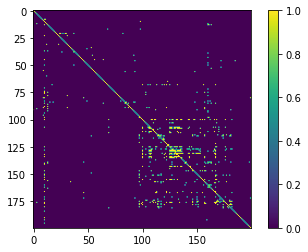

In [8]:
plt.imshow(adj[800:1000,800:1000], cmap='viridis')
plt.colorbar()
plt.show()

In [22]:
adj = normalize(adj, norm="l1")

In [23]:
adj

array([[0.04761905, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03333333, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03225806,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03571429]])

In [27]:
adj = torch.from_numpy(adj).to(dtype=torch.float)

In [28]:
adj

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [12]:
df_ft.drop(['mid'],inplace=True,axis=1)

In [18]:
df_ft

,fans,friend,cur_level,archive_count,like_num,sex_女,sex_男,official_role_1,official_role_2,official_role_3,...,video_num_鬼畜_ttl,video_num_电影_7d,video_num_电影_15d,video_num_电影_30d,video_num_电影_90d,video_num_电影_180d,video_num_电影_1y,video_num_电影_3y,video_num_电影_5y,video_num_电影_ttl
0,9.667322,0.693147,4,5.298317,10.768022,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.562509,1.945910,6,7.428927,14.042280,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.268672,4.007333,5,2.397895,11.400361,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.777639,4.060443,6,4.158883,12.899705,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.578142,2.639057,6,4.905275,13.281015,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9209,10.527606,3.258097,5,4.158883,13.706819,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9210,13.744550,3.526361,6,5.799093,15.821214,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9211,13.283601,6.558198,6,5.135798,14.337744,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9212,12.268742,4.094345,6,3.713572,14.308847,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
torch.tensor(df_ft.values)

tensor([[ 9.6673,  0.6931,  4.0000,  ...,  0.0000,  0.0000,  0.0000],
        [12.5625,  1.9459,  6.0000,  ...,  0.0000,  0.0000,  0.0000],
        [12.2687,  4.0073,  5.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [13.2836,  6.5582,  6.0000,  ...,  0.0000,  0.0000,  0.0000],
        [12.2687,  4.0943,  6.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.2864,  0.0000,  6.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)